In [1]:
import pandas as pd
import warnings
import numpy as np

# calling functions from the manual created util file
from util import df_first_look, file_read, sessions_final_df_cleaning
from datetime import datetime
from datetime import timedelta

# adding options to visualise all rows and columns in the project
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

# ignoring warnings
warnings.filterwarnings("ignore")

# adding useful magic functions
%load_ext lab_black
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
# Reading all files into the data frames
(
    sessions_final_df,
    audience_df,
    tv_planning_df,
    tv_spots_df,
    tv_visits_match_df,
) = file_read()

### Descriptive Statistics to be Added For Each Table

### Target Channels 

Regarding the assignment rules we need to include a certain list of channels.

● Search engines (SEO + SEA, Brand)

● Direct Type-in Traffic

From the unique channel lists, I have selected these ones to be included in the project.

In [3]:
channel_list = [
    "Direct App",
    "Bing CPC Brand",
    "Direct",
    "Organic Search Brand",
    "Google CPC Brand",
    "Google CPC Non Brand",
    "Organic Search Non Brand",
    "Bing CPC Non Brand",
    "Apple Search Ads",
    "Google Paid App Non Brand",
    "Display Brand",
]
print("Initial sessions_final_df table count:", sessions_final_df.shape[0])
print("")
sessions_final_df = sessions_final_df_cleaning(sessions_final_df, channel_list)
print(
    "Final sessions_final_df table count after channel filtering:",
    sessions_final_df.shape[0],
)

Initial sessions_final_df table count: 1058463

Final sessions_final_df table count after channel filtering: 628032


### TV Planning Date Filtering

In the sessions data set we only focus on 15th of May 2020. Regarding this we need to filter out other days from TV Planning data set.

In [4]:
# getting only 15th of May 2020 data
tv_planning_df = tv_planning_df[
    (tv_planning_df["block_start_time"].dt.strftime("%Y-%m-%d") == "2020-05-15")
].copy()

### TV Planning and TV Spots: Joining and Feature Calculations

* TV Planning Data Frame is our main data set to get the advertisement block hours.
* TV Spot Data Frame contains information about each advertisement. 
* We need to join these tables and calculate when our advertisements start and end during each show's advertisement block hours.

In [5]:
# we are joining tables on spot_id.
tv_show_spot_df = pd.merge(tv_planning_df, tv_spots_df, how="left", on="spot_id")

In [6]:
tv_show_spot_df.head()

,tvp_id,block_start_time,tv_show,block_size,block_position,spot_id,spot_name,duration
0,10001127236681063068_1553644644,2020-05-15 18:05:00,First Dates - Ein Tisch für zwei,420.0,345.0,4234.0,springsummer_branding,30 secs
1,10001127236681063068_1553644645,2020-05-15 18:10:00,SOKO Kitzbühel,300.0,270.0,6232.0,springsummer_outfitfashionA,15 secs
2,10001127236681063068_1553644646,2020-05-15 19:35:00,Alles was zählt,480.0,60.0,8331.0,springsummer_saleB,7 secs
3,10001127236681063068_15536446461,2020-05-15 19:40:00,Comeback oder weg?,300.0,180.0,7224.0,springsummer_saleA,7 secs
4,10001127236681063068_1553644647,2020-05-15 20:15:00,Jack Reacher,60.0,15.0,6232.0,springsummer_outfitfashionA,15 secs


In [7]:
# in duration column there is a string suffix ' secs'. We need to clean this part to have numeric values.
tv_show_spot_df["duration_numeric"] = pd.to_numeric(
    tv_show_spot_df["duration"].str.split(" ", expand=True)[0]
)

### Advertisement Start and End Time Calculations

* `block_start_time`: Advertisement starting time during the tv show
* `block_size`: Total advertisement time block in terms of seconds
* `block_position`: When our advertisement starts in terms of seconds in the block_size
* `duration`: How long our advertiesement is shown in terms of seconds

Here we need to calculate when our advertisement starts and ends in terms of normal time format

In [8]:
# calculating when our advertisement starts during the tv show advertiesement block
tv_show_spot_df["block_position_second"] = pd.to_timedelta(
    tv_show_spot_df["block_position"], unit="s"
)
tv_show_spot_df["ads_start_time"] = (
    tv_show_spot_df["block_start_time"] + tv_show_spot_df["block_position_second"]
)

In [9]:
# calculating when our advertisement ends during the tv show advertiesement block
tv_show_spot_df["duration_numeric_second"] = pd.to_timedelta(
    tv_show_spot_df["duration_numeric"], unit="s"
)
tv_show_spot_df["ads_end_time"] = (
    tv_show_spot_df["ads_start_time"] + tv_show_spot_df["duration_numeric_second"]
)

In [10]:
# dropping unused columns
tv_show_spot_df.drop(
    columns=["duration_numeric", "block_position_second", "duration_numeric_second"],
    inplace=True,
)

In [11]:
tv_show_spot_df

,tvp_id,block_start_time,tv_show,block_size,block_position,spot_id,spot_name,duration,ads_start_time,ads_end_time
0,10001127236681063068_1553644644,2020-05-15 18:05:00,First Dates - Ein Tisch für zwei,420.0,345.0,4234.0,springsummer_branding,30 secs,2020-05-15 18:10:45,2020-05-15 18:11:15
1,10001127236681063068_1553644645,2020-05-15 18:10:00,SOKO Kitzbühel,300.0,270.0,6232.0,springsummer_outfitfashionA,15 secs,2020-05-15 18:14:30,2020-05-15 18:14:45
2,10001127236681063068_1553644646,2020-05-15 19:35:00,Alles was zählt,480.0,60.0,8331.0,springsummer_saleB,7 secs,2020-05-15 19:36:00,2020-05-15 19:36:07
3,10001127236681063068_15536446461,2020-05-15 19:40:00,Comeback oder weg?,300.0,180.0,7224.0,springsummer_saleA,7 secs,2020-05-15 19:43:00,2020-05-15 19:43:07
4,10001127236681063068_1553644647,2020-05-15 20:15:00,Jack Reacher,60.0,15.0,6232.0,springsummer_outfitfashionA,15 secs,2020-05-15 20:15:15,2020-05-15 20:15:30


### Calculating Background Noise

In a next step the background noise of visits from these channels is estimated:
* The TV relevant visits are aggregated on a per-minute basis
* Background noise value is calculated per minute:

background noise for one minute x = median(visits in minute x-20; visits in minute x+20)

In [12]:
tv_show_spot_df.head()

,tvp_id,block_start_time,tv_show,block_size,block_position,spot_id,spot_name,duration,ads_start_time,ads_end_time
0,10001127236681063068_1553644644,2020-05-15 18:05:00,First Dates - Ein Tisch für zwei,420.0,345.0,4234.0,springsummer_branding,30 secs,2020-05-15 18:10:45,2020-05-15 18:11:15
1,10001127236681063068_1553644645,2020-05-15 18:10:00,SOKO Kitzbühel,300.0,270.0,6232.0,springsummer_outfitfashionA,15 secs,2020-05-15 18:14:30,2020-05-15 18:14:45
2,10001127236681063068_1553644646,2020-05-15 19:35:00,Alles was zählt,480.0,60.0,8331.0,springsummer_saleB,7 secs,2020-05-15 19:36:00,2020-05-15 19:36:07
3,10001127236681063068_15536446461,2020-05-15 19:40:00,Comeback oder weg?,300.0,180.0,7224.0,springsummer_saleA,7 secs,2020-05-15 19:43:00,2020-05-15 19:43:07
4,10001127236681063068_1553644647,2020-05-15 20:15:00,Jack Reacher,60.0,15.0,6232.0,springsummer_outfitfashionA,15 secs,2020-05-15 20:15:15,2020-05-15 20:15:30


In [13]:
ads_start_list = list((tv_show_spot_df["ads_start_time"].dt.strftime("%Y-%m-%d %H:%M")))

In [18]:
ads_start_list

['2020-05-15 18:10',
 '2020-05-15 18:14',
 '2020-05-15 19:36',
 '2020-05-15 19:43',
 '2020-05-15 20:15']

### Deep Dive Analysis On TV Advertisement Effects

<AxesSubplot:xlabel='date_hour_minute'>

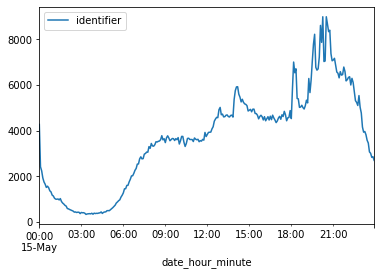

In [21]:
sessions_final_df_reporting = pd.read_csv("case_may_2020_sessions_final.csv")
sessions_final_df_reporting_df = (
    sessions_final_df_reporting.groupby(by=["date_hour_minute"])["identifier"]
    .count()
    .reset_index()
)
sessions_final_df_reporting_df["date_hour_minute"] = pd.to_datetime(
    sessions_final_df_reporting_df["date_hour_minute"]
)
sessions_final_df_reporting_df.set_index("date_hour_minute", inplace=True)
sessions_final_df_reporting_df.resample("5T").apply(sum).plot()

<AxesSubplot:xlabel='date_hour_minute'>

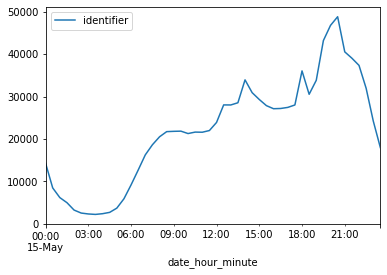

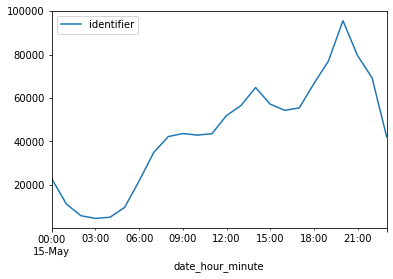

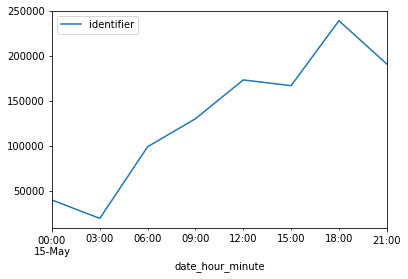

In [23]:
sessions_final_df_reporting_df.resample("30T").apply(sum).plot()
sessions_final_df_reporting_df.resample("h").apply(sum).plot()
sessions_final_df_reporting_df.resample("3h").apply(sum).plot()

In [14]:
sessions_final_df_aggregated = (
    sessions_final_df.groupby(by=["date_hour_minute"])["identifier"]
    .count()
    .reset_index()
    .rename(columns={"identifier": "identifier_count"})
)

In [16]:
sessions_final_df_aggregated["date_hour_minute"] = pd.to_datetime(
    sessions_final_df_aggregated["date_hour_minute"]
)

In [ ]:
median_df = pd.DataFrame(columns=["time", "time_new", "time_new_median"])

for time in ads_start_list:
    for i in range(0, 6):
        time_new = datetime.strptime(time, "%Y-%m-%d %H:%M") + timedelta(minutes=i)
        time_new_minus_20 = time_new - timedelta(minutes=20)
        time_new_plus_20 = time_new + timedelta(minutes=20)
        time_new_median = sessions_final_df_aggregated[
            (sessions_final_df_aggregated["date_hour_minute"] >= time_new_minus_20)
            & (sessions_final_df_aggregated["date_hour_minute"] <= time_new_plus_20)
        ]["identifier_count"].median()

        to_append = [time, time_new, time_new_median]
        a_series = pd.Series(to_append, index=median_df.columns)
        median_df = median_df.append(a_series, ignore_index=True)

In [ ]:
median_df["peak_threshold"] = median_df["time_new_median"] * 1.15

In [ ]:
threshold_control = pd.merge(
    median_df,
    sessions_final_df_aggregated,
    how="inner",
    left_on="time_new",
    right_on="date_hour_minute",
)

In [ ]:
threshold_control["prob"] = np.where(
    threshold_control["identifier_count"] > threshold_control["peak_threshold"],
    (threshold_control["identifier_count"] - threshold_control["time_new_median"])
    / threshold_control["identifier_count"],
    0,
)

In [ ]:
threshold_control

In [ ]:
# we need to merge to the tv_show_spot_df table. don,t forget to use seconds to merge